In [484]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass
from skimage import io
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.signal import savgol_filter
import os
from corrLib import corrS, corrI, divide_windows, distance_corr, corrIseq, readseq
from scipy.signal import savgol_filter
from corrLib import boxsize_effect_spatial
import matplotlib as mpl
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
%matplotlib nbagg

In [366]:
img = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\80-2bp.tif')
X, Y, I = divide_windows(img, windowsize=[40, 40], step=40)
CI = corrI(X, Y, I)
dc = distance_corr(X, Y, CI)

<IPython.core.display.Javascript object>


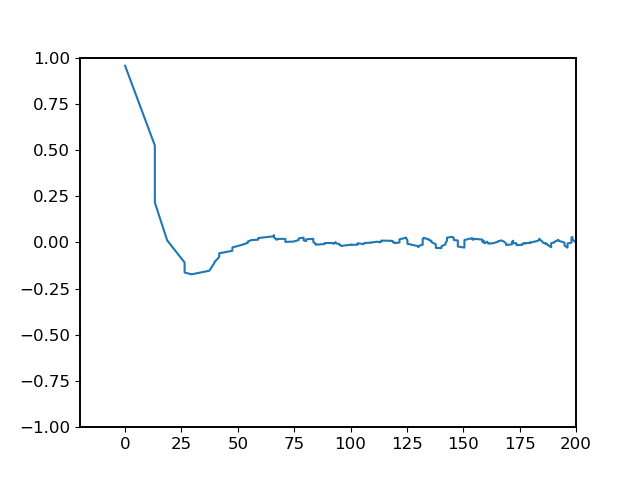

[-20, 200, -1, 1]

In [372]:
plt.plot(dc.R*.33, savgol_filter(dc.C, 11, 3))
plt.axis([-20, 200, -1, 1])

<IPython.core.display.Javascript object>


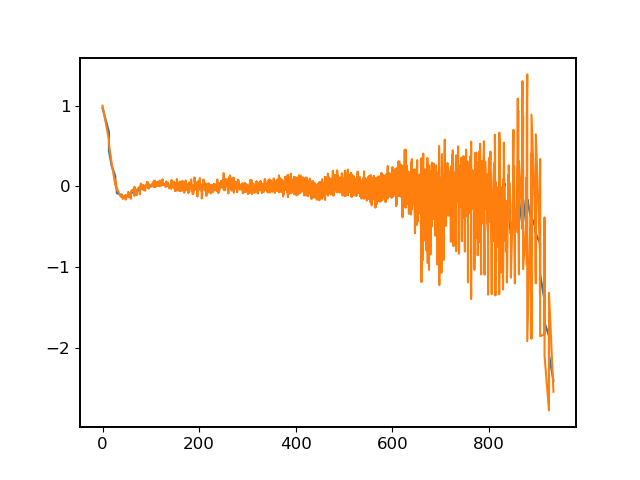

In [448]:
img = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\80-2.tif')
bp = bpass(img, 5, 100)
X, Y, I = divide_windows(bp, windowsize=[40, 40], step=40)
CI = corrI(X, Y, I)
dc = distance_corr(X, Y, CI)
plt.plot(dc.R*.33, savgol_filter(dc.C, 11, 3))
# plt.axis([-20, 200, -1, 1])

## Correlation vs. density

### Boxsize = 6.6 um

<IPython.core.display.Javascript object>


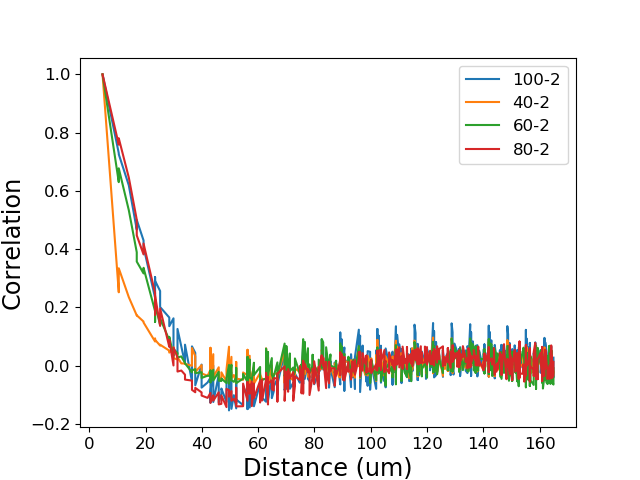

In [100]:
data = pd.read_csv(r'E:\Github\Python\Correlation\test_images\cl\result\cl_data_20.csv')
names = data.Name.drop_duplicates()
for name in names:
    dc = data.loc[data.Name==name]
    x = np.array(dc.R)
    y = np.array(dc.C)
    xx = x[(x<500)]
    yy = savgol_filter(y[(x<500)], 51, 3)
    yy = y[x<500]
    plt.plot(xx*0.33, yy, label=name)
plt.legend()
plt.xlabel('Distance (um)')
plt.ylabel('Correlation')
plt.savefig(r'E:\Github\Python\Correlation\test_images\cl\result\cl_plot_20.png', dpi=150)

### Boxsize = 1.8 um

<IPython.core.display.Javascript object>


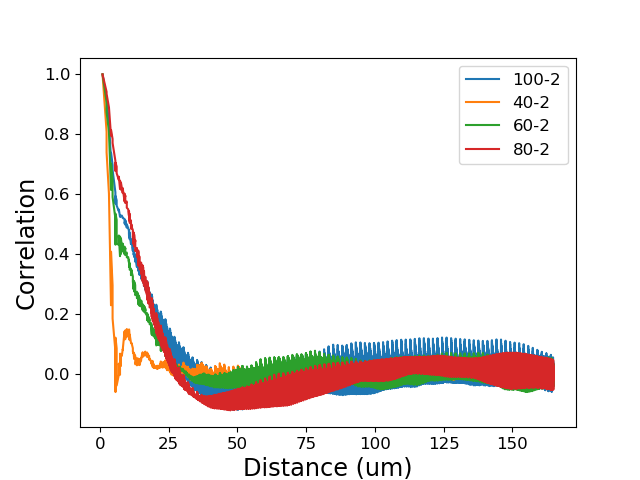

In [103]:
data = pd.read_csv(r'E:\Github\Python\Correlation\test_images\cl\result\cl_data_5.csv')
for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]
    
    x = np.array(subdata.R)
    y = np.array(subdata.C)
    xx = x[(x<500)]
    yy = savgol_filter(y[(x<500)], 1001, 3)
    yy = y[x<500]
    plt.plot(xx*0.33, yy, label=name)
plt.legend()
plt.xlabel('Distance (um)')
plt.ylabel('Correlation')
plt.savefig(r'E:\Github\Python\Correlation\test_images\cl\result\cl_plot_5.png', dpi=150)

## Box size effect on spatial intensity correlation

### boxsize effect on bandpassed image

<IPython.core.display.Javascript object>


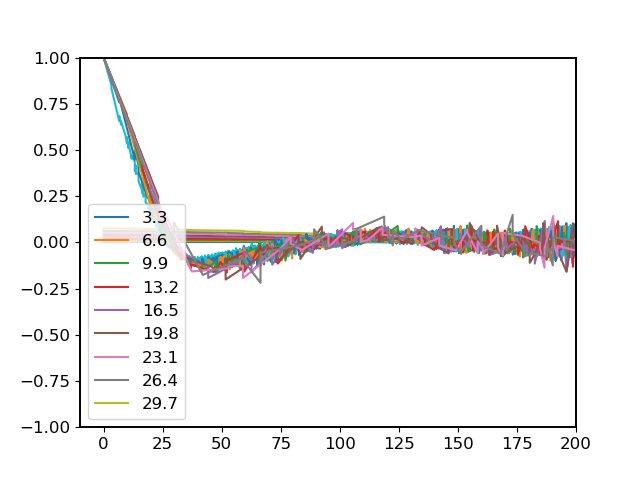

In [452]:
img = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\80-2.tif')
bp = bpass(img, 5, 100)
boxsize = range(10, 100, 10)
mpp= 0.33
data = boxsize_effect_spatial(bp, boxsize, mpp)

<IPython.core.display.Javascript object>


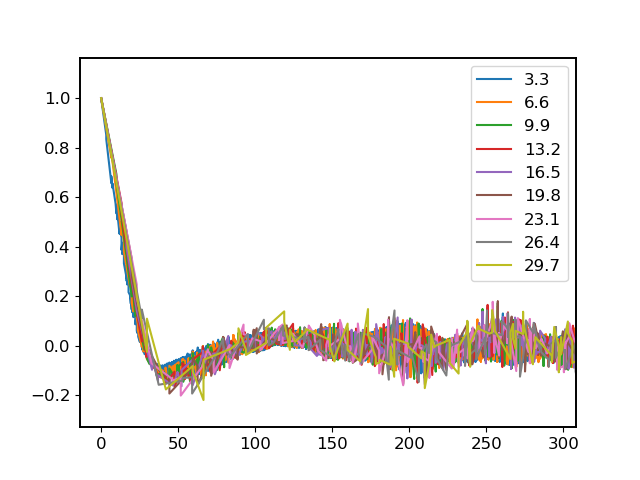

In [460]:
for kw in data:
    x = data[kw].R
    y = data[kw].C
    plt.plot(x, y, label=kw)
plt.axis([-10, 200, -1, 1])
plt.legend()

### bandpass effect on spatial correlation

In [7]:
# No bpass
nbdata = pd.read_csv(r'E:\Github\Python\Correlation\test_images\boxsize_effect\80-2_data.csv')
bdata = pd.read_csv(r'E:\Github\Python\Correlation\test_images\boxsize_effect\boxsize_effect_data.csv')
nbdata1 = nbdata.loc[nbdata.boxsize_um==3.3]
bdata1 = bdata.loc[bdata.boxsize==3.3]

<IPython.core.display.Javascript object>


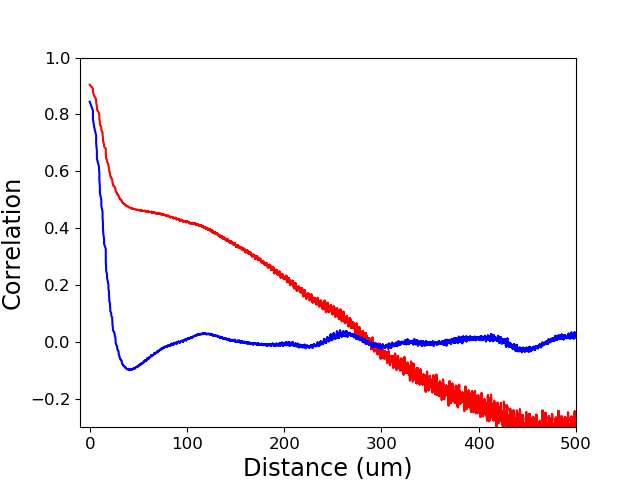

In [42]:
%matplotlib nbagg
plt.plot(nbdata1.R, savgol_filter(nbdata1.C, 101, 3), color='red')
plt.plot(bdata1.R, savgol_filter(bdata1.C, 101, 3), color='blue')
plt.axis([-10, 500, -0.3, 1])
plt.xlabel('Distance (um)')
plt.ylabel('Correlation')
plt.savefig(r'E:\Github\Python\Correlation\test_images\boxsize_effect\bpass_effect.png', dpi=150)

## Direct measurement of characteristic length scale

In [340]:
img = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\80-2bp.tif')
rows = np.floor(np.linspace(0, img.shape[0]-1, 5))
rowI = img[[   0,  511, 1023, 1535, 2047], :]
    

array([ 88,  80,  68, ..., 169, 179, 175], dtype=uint8)

<IPython.core.display.Javascript object>


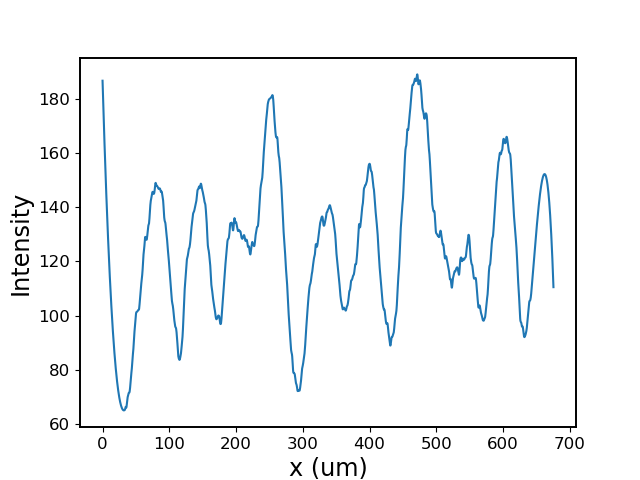

Text(0, 0.5, 'Intensity')

In [365]:
plt.plot(np.array(range(0, len(rowI[0])))*0.33, savgol_filter(rowI[1], 201, 3))
plt.xlabel('x (um)')
plt.ylabel('Intensity')

## Giant number fluctuation analysis

In [15]:
img = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\0001.tif')
boxsize = np.unique(np.floor(np.logspace(0, 2.5, 100)))
NList = []
dNList = []
for bs in boxsize:
    X, Y, I = divide_windows(img, windowsize=[bs, bs], step=bs)
    N = (255-I.mean())*bs*bs
    dN = I.std()*bs*bs
    NList.append(N)
    dNList.append(dN)

In [1]:
n = np.array(NList)
d = np.array(dNList)
plt.plot(n, d/n**.5)
plt.xscale('log')
plt.yscale('log')

NameError: name 'np' is not defined

### Analyze density fluctuation of an 8-bit grayscale image

In [23]:
def density_fluctuation(img8):
    # Gradually increase box size and calculate dN=std(I) and N=mean(I)
    row, col = img8.shape
    # choose maximal box size to be 1/3 of the shorter edge of the image 
    # to guarantee we have multiple boxes for each calculation, so that
    # the statistical quantities are meaningful.
    l = min(row, col)
    boxsize = np.unique(np.floor(np.logspace(0, np.log10(l/3), 100)))
    NList = []
    dNList = []
    for bs in boxsize:
        X, Y, I = divide_windows(img8, windowsize=[bs, bs], step=bs)
        N = (255-I.mean())*bs*bs
        dN = I.std()*bs*bs
        NList.append(N)
        dNList.append(dN)
    return np.array(NList), np.array(dNList)

In [308]:
folder = r'I:\Data\Wei\transient\02\i50bp'
l = readseq(folder)
data = pd.DataFrame()
for num, i in l.iterrows():
    print('Processing frame' + i.Name)
    img = io.imread(i.Dir)
    n, d = density_fluctuation(img)
    data_t = pd.DataFrame().assign(n=n, d=d, frame=i.Name)
    data = data.append(data_t)

Processing frame0000
Processing frame0001
Processing frame0002
Processing frame0003
Processing frame0004
Processing frame0005
Processing frame0006
Processing frame0007
Processing frame0008
Processing frame0009
Processing frame0010
Processing frame0011
Processing frame0012
Processing frame0013
Processing frame0014
Processing frame0015
Processing frame0016
Processing frame0017
Processing frame0018
Processing frame0019
Processing frame0020
Processing frame0021
Processing frame0022
Processing frame0023
Processing frame0024
Processing frame0025
Processing frame0026
Processing frame0027
Processing frame0028
Processing frame0029
Processing frame0030
Processing frame0031
Processing frame0032
Processing frame0033
Processing frame0034
Processing frame0035
Processing frame0036
Processing frame0037
Processing frame0038
Processing frame0039


In [386]:
data.to_csv(r'I:\Data\Wei\transient\02\i50bp\GNFdata.csv', index=False)

<IPython.core.display.Javascript object>


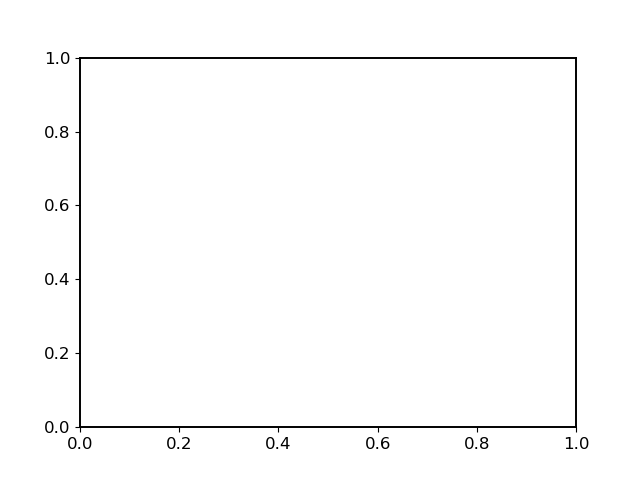

In [389]:
folder = r'I:\Data\Wei\transient\02\i50bp\GNFplot'
data = pd.read_csv(r'I:\Data\Wei\transient\02\i50bp\GNFdata.csv')
for frame in data.frame.drop_duplicates():
    subdata = data.loc[data.frame==frame]
    plt.plot(subdata.n, subdata.d)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('N')
    plt.ylabel('dN')
    plt.savefig(os.path.join(folder, str(frame)+'.png'), dpi=150)
    plt.cla()

In [290]:
img = io.imread(r'I:\Github\Python\Correlation\test_images\GNF\500bp.tif')
n, d = density_fluctuation(img)

<IPython.core.display.Javascript object>


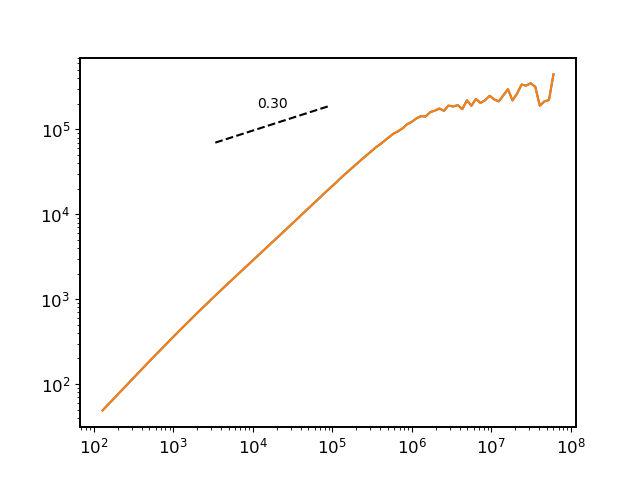

In [292]:
plt.plot(n, d)
plt.xscale('log')
plt.yscale('log')

In [393]:
xf, yf, xt, yt, slope = label_slope(n, d, location='n')

<IPython.core.display.Javascript object>


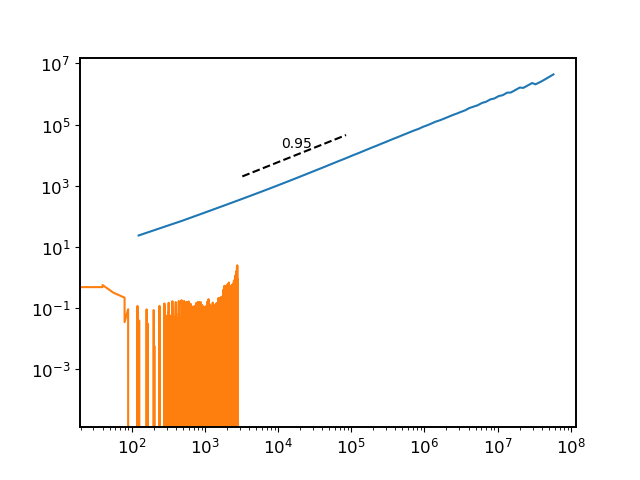

In [394]:
plt.plot(n, d)
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
plt.xscale('log')
plt.yscale('log')

### Bandpass effect on density fluctuation

In [21]:
nbimg = io.imread(r'E:\Github\Python\Correlation\test_images\boxsize_effect\80-2.tif')
bimg = io.imread(r'E:\Github\Python\Correlation\test_images\boxsize_effect\80-2bp.tif')
n, d = density_fluctuation(nbimg)
n1, d1 = density_fluctuation(bimg)

<IPython.core.display.Javascript object>


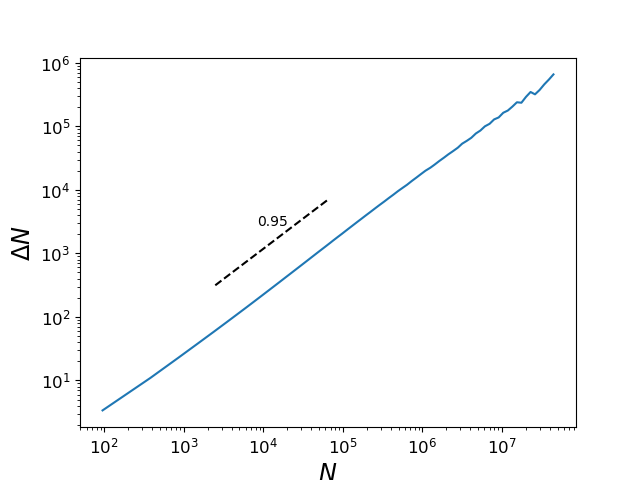

Text(8446.461496095659, 2730.038780302085, '0.95')

In [29]:
# no bpass
plt.plot(n, d)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$ ')
xf, yf, xt, yt, slope = label_slope(n, d, location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))

<IPython.core.display.Javascript object>


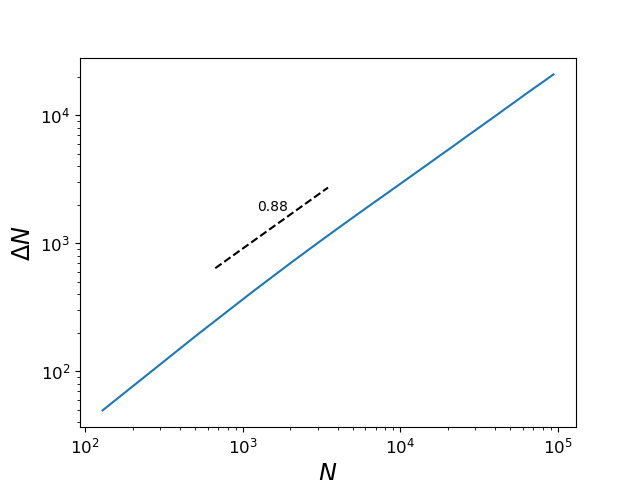

Text(1240.657235459661, 1780.7228301196167, '0.88')

In [36]:
# bpass
n1t = n1[n1<1e5]
d1t = d1[n1<1e5]
plt.plot(n1t, d1t)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$ ')
xf, yf, xt, yt, slope = label_slope(n1t, d1t, location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))

<IPython.core.display.Javascript object>


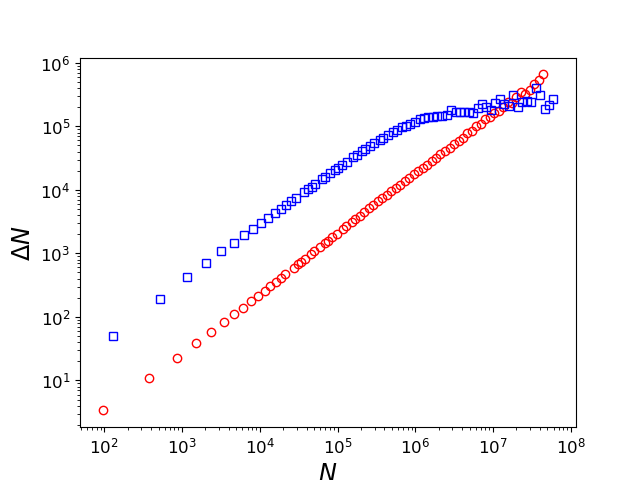

In [43]:
plt.plot(n, d, marker='o', ls='', mfc=(0,0,0,0), mec='red')
plt.plot(n1, d1, marker='s', ls='', mfc=(0,0,0,0), mec='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$ ')
plt.savefig(r'E:\Github\Python\Correlation\test_images\boxsize_effect\bpass_effect_DF.png', dpi=150)

### Density fluctuation vs. density

In [68]:
# stationary
folder = r'E:\Github\Python\Correlation\test_images\GNF\stat'
l = readseq(folder)
data_stat = pd.DataFrame()
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    img = bpass(img, 3, 100)
    n, d = density_fluctuation(img)
    data_t = pd.DataFrame().assign(n=n, d=d, Name=i.Name)
    data_stat = data_stat.append(data_t)
data_stat.to_csv(os.path.join(folder, 'data_bp.csv'))

In [73]:
# motion
folder = r'E:\Github\Python\Correlation\test_images\GNF\motion'
l = readseq(folder)
data_stat = pd.DataFrame()
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    img = bpass(img, 3, 100)
    n, d = density_fluctuation(img)
    data_t = pd.DataFrame().assign(n=n, d=d, Name=i.Name)
    data_stat = data_stat.append(data_t)
data_stat.to_csv(os.path.join(folder, 'data_bp.csv'))

#### Original image density fluctuation

In [80]:
data_stat = pd.read_csv(r'E:\Github\Python\Correlation\test_images\GNF\stat\data.csv')
data_mot = pd.read_csv(r'E:\Github\Python\Correlation\test_images\GNF\motion\data.csv')

<IPython.core.display.Javascript object>


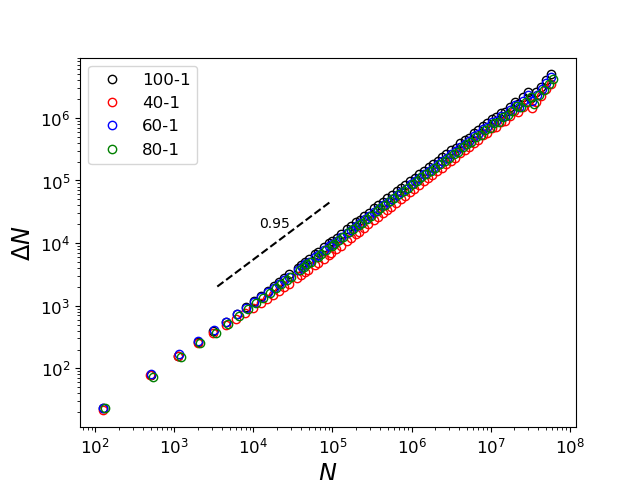

In [85]:
colors = ['black', 'red', 'blue', 'green']
for num, name in enumerate(data_stat.Name.drop_duplicates()):
    subdata = data_stat.loc[data_stat.Name==name]
    plt.plot(subdata.n, subdata.d, label=name, ls='', marker='o', mfc=(0,0,0,0), mec=colors[num])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$ ')
plt.legend()
xf, yf, xt, yt, slope = label_slope(subdata.n, subdata.d, location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
plt.savefig(r'E:\Github\Python\Correlation\test_images\GNF\stat\DF_plot_stat.png', dpi=150)

<IPython.core.display.Javascript object>


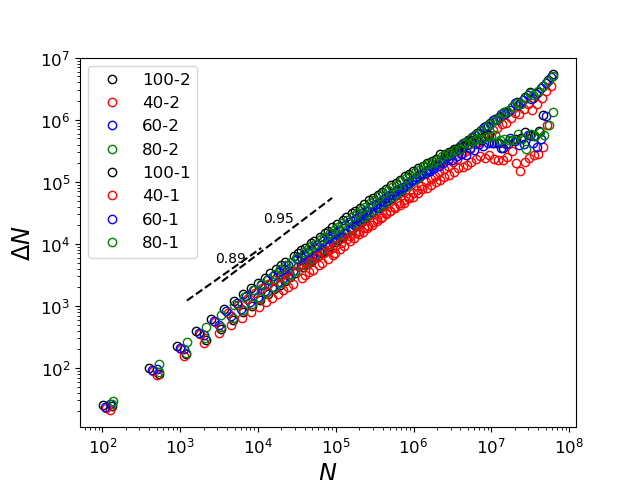

In [86]:
for num, name in enumerate(data_mot.Name.drop_duplicates()):
    subdata = data_mot.loc[data_mot.Name==name]
    plt.plot(subdata.n, subdata.d, label=name, ls='', marker='o', mfc=(0,0,0,0), mec=colors[num])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$ ')
plt.legend()
xf, yf, xt, yt, slope = label_slope(subdata.n, subdata.d, location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
plt.savefig(r'E:\Github\Python\Correlation\test_images\GNF\stat\DF_plot_mot.png', dpi=150)

#### Bpassed images density fluctuation

In [74]:
data_stat_bp = pd.read_csv(r'E:\Github\Python\Correlation\test_images\GNF\stat\data_bp.csv')
data_mot_bp = pd.read_csv(r'E:\Github\Python\Correlation\test_images\GNF\motion\data_bp.csv')

<IPython.core.display.Javascript object>


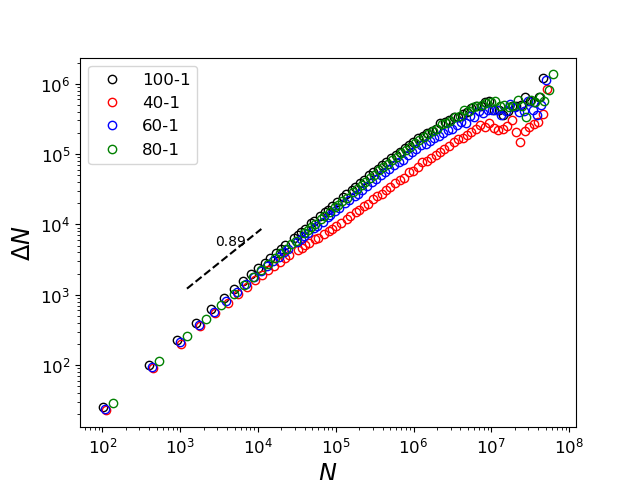

In [88]:
colors = ['black', 'red', 'blue', 'green']
for num, name in enumerate(data_stat_bp.Name.drop_duplicates()):
    subdata = data_stat_bp.loc[data_stat_bp.Name==name]
    plt.plot(subdata.n, subdata.d, label=name, ls='', marker='o', mfc=(0,0,0,0), mec=colors[num])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$ ')
plt.legend()
xf, yf, xt, yt, slope = label_slope(subdata.n.loc[subdata.n<1e6], subdata.d.loc[subdata.n<1e6], location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
plt.savefig(r'E:\Github\Python\Correlation\test_images\GNF\stat\DF_plot_stat_bp.png', dpi=150)

<IPython.core.display.Javascript object>


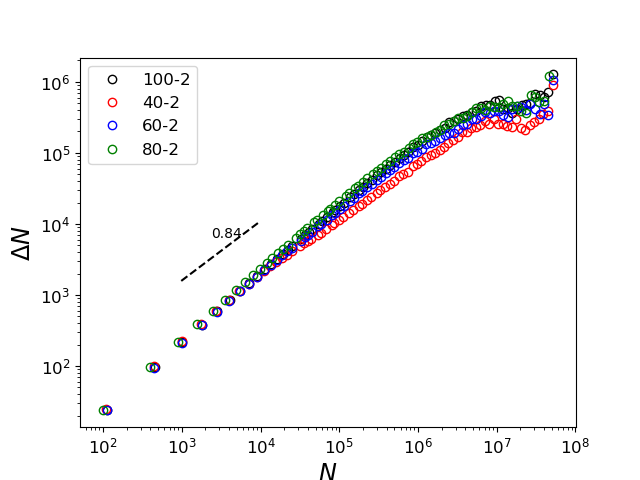

In [89]:
for num, name in enumerate(data_mot_bp.Name.drop_duplicates()):
    subdata = data_mot_bp.loc[data_mot_bp.Name==name]
    plt.plot(subdata.n, subdata.d, label=name, ls='', marker='o', mfc=(0,0,0,0), mec=colors[num])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$ ')
plt.legend()
xf, yf, xt, yt, slope = label_slope(subdata.n.loc[subdata.n<1e6], subdata.d.loc[subdata.n<1e6], location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
plt.savefig(r'E:\Github\Python\Correlation\test_images\GNF\motion\DF_plot_mot_bp.png', dpi=150)

## Compare bpass image with original image

In [485]:
img = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\80-2.tif')
bp = bpass(img, 3, 100)

<IPython.core.display.Javascript object>


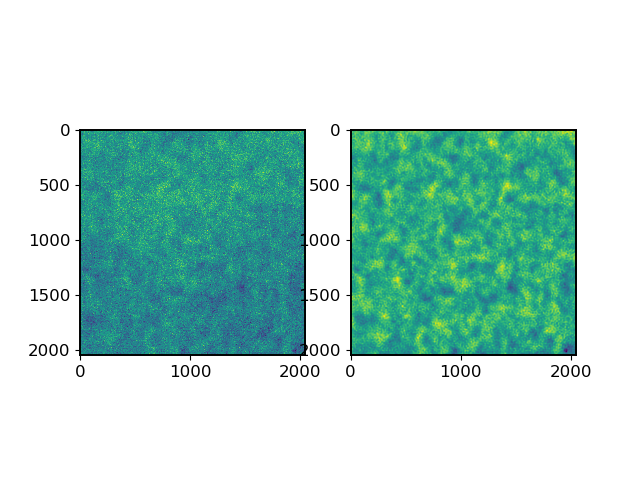

In [486]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(bp)

In [495]:
a = np.random.random(50)
a1 = np.log(a*255)
std1 = a.std()
a2 = np.log(a)
std2 = a2.std()
std1, std2

(0.2699215391039348, 0.9563498802574969)

<IPython.core.display.Javascript object>


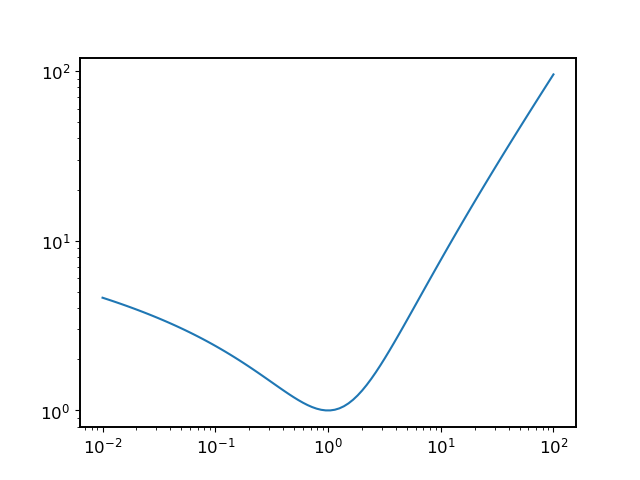

In [498]:
x = np.logspace(-2, 2, 100)
y = -np.log(x) + x
plt.plot(x, y)
plt.xscale('log')
plt.yscale('log')

In [501]:
a2.max()

-0.015522833140260473